In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

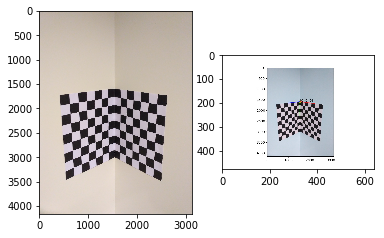

In [182]:
img = cv2.imread('calib-object.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_ref = cv2.imread('calib-object-legend.jpg')
img_ref = cv2.cvtColor(img_ref,cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_ref)

In [183]:
x1 = [(1548.2210910175404, 1606.9701081799199), (1666.64963533335, 1612.6095626711485), (1790.7176341403888, 1635.167380636065), (1931.703996421114, 1652.0857441097519), (2083.9692676842974, 1669.0041075834388), (2247.513447929939, 1697.201380039584), (2433.615446140497, 1714.1197435132713), (2619.7174443510544, 1742.3170159694164), (1548.2210910175404, 1770.5142884255615), (1666.64963533335, 1793.0721063904775), (1796.357088631618, 1815.6299243553935), (1937.343450912343, 1843.8271968115387), (2083.9692676842974, 1872.0244692676838), (2236.234538947481, 1894.5822872325998)]
z1 = [(1407.2347287368152, 1623.8884716536068), (1277.5272754385483, 1640.8068351272937), (1130.901458666593, 1652.0857441097519), (978.6361874034096, 1669.0041075834388), (792.5341891928524, 1691.5619255483548), (623.3505544559816, 1714.1197435132713), (431.6091017541953, 1725.398652495729), (1418.5136377192734, 1787.4326518992484), (1283.1667299297765, 1826.9088333378513), (1136.5409131578222, 1843.8271968115387), (989.9150963858679, 1860.7455602852256), (815.092007157768, 1877.663923758913)]
img_coords = np.asarray(x1+z1).astype('float32')

In [184]:
w1 = [[0,0,0],[1,0,0],[2,0,0],[3,0,0],[4,0,0],[5,0,0],[6,0,0],[7,0,0],
               [0,1,0],[1,1,0],[2,1,0],[3,1,0],[4,1,0],[5,1,0],[0,0,1],[0,0,2],
               [0,0,3],[0,0,4],[0,0,5],[0,0,6],[0,0,7],[0,1,1],[0,1,2],[0,1,3],
               [0,1,4],[0,1,5]]
world_coords = np.asarray(w1).astype('float32')

## Direct Linear Transform
We will be using this method to find the 11 paramaters of the projected matrix P. (5 intrinsic and 6 extrinsic paramters). The projected matrix P maps the point from object space to camera space. 
P = KR[I|-RC]. The algorithm to compute DLT is as follows - 
+ Define P
+ Get atleast 6 points
+ Restructure P to M
+ Formulate Least square error equation
+ Calculate SVD for M
+ Last column of V.T of decomposition is the solution for P
+ Calculate t
+ QR decomposition for K and R

In [185]:
def dlt(img,img_coords,world_coords):
    npts = img_coords.shape[0]
    M = np.zeros((npts*2,12))
    for i in range(npts):
        X,Y,Z = world_coords[i]
        u,v = img_coords[i]
        M[2*i] = [0,0,0,0,-X,-Y,-Z,-1,u*X,u*Y,u*Z,u]
        M[2*i+1] = [-X,-Y,-Z,-1,0,0,0,0,v*X,v*Y,v*Z,v]
    u1,s,vh1 = np.linalg.svd(M)
    Pt = vh1[-1]
    P = vh1[-1].reshape(3,4)
    nimg = img.copy()
    n = np.concatenate((world_coords.T,np.ones((1,npts))),axis=0)
    
#     mse error between points
    img_pred = P@n
    img_pred = img_pred[[1,0],:]/img_pred[2,:]
    mse = np.mean((img_coords-img_pred.T)**2)
    for i in range(npts):
        cv2.circle(nimg,(int(img_pred[0,i]),int(img_pred[1,i])  ),npts,(0,255,0),int(0.009*img.shape[0]))

    hom = P[:,0:3]
    pt = P[:,3]
    hominv = np.linalg.inv(hom)
    t = hominv@pt
    R,K = np.linalg.qr(hom)
    K = K/K[2,2]
    x = M@Pt
#     overall error
    error = x@x
    return P,K,R,t,error,mse,nimg

Projected Matrix
[[ 1.89129965e-02 -8.55115557e-02  1.44162009e-02 -7.15221120e-01]
 [-2.71613663e-02 -1.06964917e-02  7.65585212e-02 -6.88380297e-01]
 [ 1.58017646e-05 -5.72722382e-06  1.29859662e-05 -4.45585664e-04]]
Intrinsic Matrix
[[-6.77956379e+02  8.21109676e+02  1.11819591e+03]
 [ 0.00000000e+00  1.56264060e+03 -1.13845489e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Rotation Matrix
[[-5.71433564e-01 -8.20648320e-01 -1.28551984e-04]
 [ 8.20648191e-01 -5.71433551e-01  4.92260192e-04]
 [-4.77431417e-04  1.75798043e-04  9.99999871e-01]]
Translation Matrix
[-15.62932847   2.5157958  -14.18501829]
Error
0.00016126513070145794


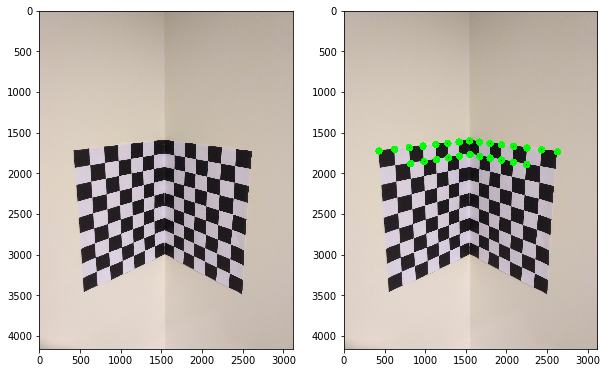

In [186]:
P,K,R,t,e,m,ni = dlt(img,img_coords,world_coords)
print("Projected Matrix")
print(P)
print("Intrinsic Matrix")
print(K)
print("Rotation Matrix")
print(R)
print("Translation Matrix")
print(t)
print("Error")
print(e)
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(ni)

## RANSAC
We implement DLT using RANSAC. The idea behind RANSAC is to find a model that is not an outlier and this mode of sampling is very efficient in making the model robust. In this case we choose a subset of data and compute the Projection matrix and do this step for N times. N is chosen such that the probability of having atleast one inlier is 0.99. In this case we run it for 250 times. We only store the best P so far on the basis of error measured. The algorithm is as follows - 
+ Take n points
+ Sample atleast 6 points
+ Calculate error by calibrating against those 6 points
+ Store the best cases
+ Repeat

In [187]:
N = 250
y1 = [(1542.5816365263122, 2858.9290052327624), (1661.010180842121, 2920.9630046362818), (1779.4387251579305, 2960.4391860748847), (1903.5067239649693, 3033.7520944608623), (2044.4930862456945, 3107.0650028468394), (2191.118903017649, 3163.4595477591297), (2343.384174280832, 3231.1330016538777), (2501.2889000352448, 3315.7248190223136), (1424.1530922105026, 2915.3235501450526), (1294.4456389122347, 2960.4391860748847)]
y2 = [[0,8,0],[1,8,0],[2,8,0],[3,8,0],[4,8,0],[5,8,0],[6,8,0],[7,8,0],[0,8,1],[0,8,2]]
img_rcoords = np.asarray(x1+z1+y1).astype('float32')
world_rcoords = np.asarray(w1+y2).astype('float32')

In [188]:
best = {}
least_error = 1e10
batch_size = img_rcoords.shape[0]
for i in range(N):
    mini = np.random.choice(batch_size, 6, replace=False)
    img_ncood = img_rcoords[mini]
    world_ncood = world_rcoords[mini]
    try:
        P1,K1,R1,t1,e1,m1,n1 = dlt(img,img_ncood,world_ncood)
        print(e1)
        if e1 < least_error:
            least_error = e1
            best['P'] = P1
            best['R'] = R1
            best['K'] = K1
            best['t'] = t1
            best['e'] = e1
            best['ni'] = n1
#     incase of singular matrices (all pts are on the same plane)
    except Exception as e:
        pass
    

9.931281339061423e-06
1.8884143649585162e-23
1.1683534508936293e-05
5.831873663106932e-06
2.6719907550557183e-06
3.1744048626345613e-07
1.1756530250013521e-07
1.6716745995189835e-06
1.8118014184044934e-06
1.384739354103538e-07
1.379241570685423e-05
5.099975527373689e-24
8.115290020960666e-27
1.1423206592246811e-24
1.6953197261436567e-26
6.237336373551789e-08
4.7231112885523925e-07
8.012987262589273e-11
3.362393928894647e-06
3.471219364481657e-24
8.51487697038911e-26
5.725100274479089e-08
1.5029378664266617e-06
9.078729603849803e-06
1.4762821567983307e-06
4.62899885286555e-07
1.7505851685412062e-28
4.1520822781908965e-07
1.2999067279701943e-23
6.20890563748057e-08
3.5208144083662747e-10
1.9736545737245593e-24
3.2525792203972227e-07
7.994343881364557e-07
2.5476144823422273e-08
1.6500552871583969e-06
1.4869649813268983e-25


/home/gera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


5.151009919032142e-06
3.0334324900978013e-06
8.703015623005071e-06
7.675150658810472e-25
5.242125686474661e-06
6.848132857280573e-06
3.518194816339007e-06
8.797312953781924e-08
1.231830715644743e-06
8.340875465340576e-26
8.244153261599644e-06
5.007753095737926e-27
1.2133468889709407e-05
1.9987115163129505e-23
1.1281623605607003e-06
6.134622600192102e-24
1.472492402619945e-06
1.0758184954017093e-07
8.360466306053502e-08
3.3910733153233035e-06
3.6398496388893025e-24
7.422688945901756e-07
3.0201507003557725e-07
1.307141246398575e-07
8.459130197805409e-07
2.1211655560241024e-27
7.525367306131662e-06
2.8468586619118216e-05
7.001525337740956e-08
4.695528288143053e-06
7.382185873422803e-07
9.208375410797181e-07
1.1291693253429536e-26
2.870029768750646e-07
5.454699087941237e-07
3.620561575899655e-06
9.051775771605661e-06
1.2739795245265702e-06
2.2601391581488753e-07
6.28244530478368e-07
4.412566057425295e-25
4.196865753989493e-07
8.333539639376783e-06
7.193523814886108e-08
7.873954827370312e-0

In [189]:
print("Projected Matrix")
print(best['P'])
print("Intrinsic Matrix")
print(best['K'])
print("Rotation Matrix")
print(best['R'])
print("Translation Matrix")
print(best['t'])
print("Error")
print(best['e'])

Projected Matrix
[[-8.22066674e-01 -1.22154890e-13  8.04445486e-15 -8.24591544e-13]
 [-5.69391179e-01 -2.04613531e-14  8.66013823e-14 -8.06985671e-13]
 [-2.59863199e-04 -1.49213324e-17  7.86724201e-18 -5.10213684e-16]]
Intrinsic Matrix
[[-4.06434445e+16 -4.55491010e+03  2.27290918e+03]
 [-0.00000000e+00  2.14326394e+03  2.70732758e+03]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00]]
Rotation Matrix
[[-8.22066674e-01  5.69391236e-01 -6.02829884e-05]
 [-5.69391179e-01 -8.22066633e-01 -3.69353360e-04]
 [-2.59863199e-04 -2.69308487e-04  9.99999930e-01]]
Translation Matrix
[ 2.85325285e-12 -1.20163952e+01  6.60219983e+00]
Error
1.7505851685412062e-28


## Correction of Radial Distortion
We use opencv functions to remove radial distortion

In [196]:
img = cv2.imread('Fig1.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_coords = [(986.9155301900606, 190.11806252202905), (1102.2491527261886, 218.53359271208933), (1229.2832876935177, 243.6061193503781), (856.5383916709596, 215.1905891603176), (721.146747824201, 240.26311579860635), (981.901024862403, 348.9107312311903), (983.5725266382889, 506.03189816446593)]
world_coords = [(0,0,0),(1,0,0),(2,0,0),(0,0,1),(0,0,2),(0,1,0),(0,2,0)]
img_coords = np.asarray(img_coords).astype('float32')
world_coords = np.asarray(world_coords).astype('float32')

In [199]:
img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([world_coords[:,:3]], [img_coords[:,:2]], 
                                                   (img_gray.shape[1], img_gray.shape[0]), 
                                                   None, None, flags=(cv2.CALIB_USE_INTRINSIC_GUESS))
h,w = img_gray.shape
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
dst = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)
# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
plt.imshow(dst)


## Zhangs method for calibration

In [113]:
imgs = []
for i in range(5456,5471):
    ik = cv2.imread('IMG_'+str(i)+'.jpg')
    ik = cv2.cvtColor(ik,cv2.COLOR_BGR2RGB)
    imgs.append(ik)

In [7]:
x,y = np.meshgrid(range(6),range(8))
world_pts = np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)))).astype('float32')

In [8]:
pts3d = []
pts2d = []
for i in imgs:
    ret,corners = cv2.findChessboardCorners(i,(6,8))
    if ret:
        pts2d.append(corners)
        pts3d.append(world_pts)

In [12]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pts3d,pts2d, (i.shape[1],i.shape[0]), None, None)

In [13]:
print('Reprojection Error:', ret)
print ('Camera Calibration Matrix:')
print(mtx)
print('Distortion Parameters:')
print(dist)
print('Rotation Vectors for the images are:')
print(rvecs)
print('Translation Vectors for the images are:')
print(tvecs)

Reprojection Error: 2.4725032641802036
Camera Calibration Matrix:
[[1.36605338e+04 0.00000000e+00 3.34309802e+03]
 [0.00000000e+00 1.36769123e+04 1.49295626e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Parameters:
[[ 8.55247426e-02  1.06525955e+01 -1.54799725e-02  2.90279746e-02
  -1.70546664e+02]]
Rotation Vectors for the images are:
[array([[-0.0515688 ],
       [-0.03040108],
       [ 1.56722899]]), array([[-0.18258784],
       [ 0.17120664],
       [-1.52825193]]), array([[-0.33278926],
       [-0.31771999],
       [ 1.51029625]]), array([[-0.46693175],
       [-0.49234411],
       [ 1.43912067]]), array([[-0.23592159],
       [ 0.24248566],
       [-1.4920106 ]]), array([[-0.08059999],
       [-0.43195458],
       [-1.56581372]]), array([[ 0.15141525],
       [-0.45320542],
       [-1.54813848]]), array([[-0.06250215],
       [-0.44688962],
       [ 1.57204911]]), array([[ 0.19038303],
       [ 0.292541  ],
       [-1.48597461]]), array([[-0.16711843],
       [

### Wireframe over the computed points
Following tutorials code

In [24]:
# Function to convert the Rotation Matrix into the Euler Angles
def eulerAnglesToRotationMatrix(theta) :
    R_x = np.array([[1,0,0],[0,np.cos(theta[0]),-np.sin(theta[0])],[0,np.sin(theta[0]), np.cos(theta[0])]])
    R_y = np.array([[np.cos(theta[1]),0,np.sin(theta[1])],[0,1,0],[-np.sin(theta[1]),0,np.cos(theta[1])]])             
    R_z = np.array([[np.cos(theta[2]),-np.sin(theta[2]),0],[np.sin(theta[2]),np.cos(theta[2]),0],[0,0,1]])
    R = np.dot(R_z,np.dot(R_y,R_x))
    return R


In [78]:
def makeP(r,t):
#     r =  rvecs[4]
    R = (eulerAnglesToRotationMatrix(r))
    R = R.astype('float32')
    temp1 = np.concatenate((R,t),axis=1) 
    P = mtx@temp1
    P = P/P[2,3]
    world_pts_1 = np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)),np.ones((48,1)))).astype(np.float32)
    pred1 = []
    for i in range(48):
        projection = np.matmul(P,np.transpose(world_pts_1[i,:]))
        projection = projection/projection[2]
        pred1.append(projection[0:2])
    pred1 = np.asarray(pred1)
    return pred1

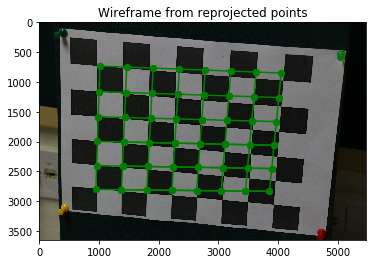

In [114]:
index = 8

pred1 = makeP(rvecs[index],tvecs[index])
idx = [5,11,17,23,29,35,41,47,53]
idx1 = [8,17,26,35,44,53]
q = 0
p = 0
for i in range(pred1.shape[0]):
    if (i == idx[q]):
        q = q + 1
        continue
    plt.plot([pred1[i][0],pred1[i+1][0]],[pred1[i][1],pred1[i+1][1]],'go-')
for i in range(9):
    i1 = i
    j =  i + 6
    while(j < 48):
        plt.plot([pred1[i1][0],pred1[j][0]],[pred1[i1][1],pred1[j][1]],'go-')
        i1 = j
        j = j + 6


plt.title('Wireframe from reprojected points')
plt.imshow(imgs[index])
plt.show() 

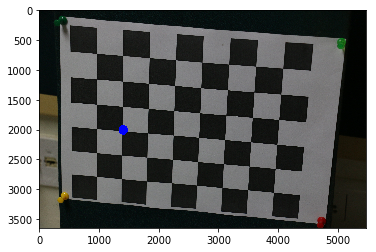

In [115]:
plt.imshow(cv2.circle(imgs[index],(int(pred1[index][0]),int(pred1[index][1])),20,(0,0,255),120))

### World Origin
The world origin is given in the blue point in above image. 

## On own image


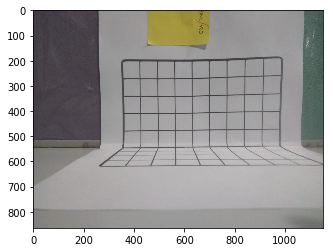

In [167]:
img = cv2.imread('Own/img0.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

### DLT Calibration

In [168]:
img_coords = [(355.30099232708835, 543.0167421305208), (363.49989154895206, 479.7680909904292), (361.1573489141339, 409.4918119458829), (356.4722636444974, 341.5580755361549), (341.2457365181791, 558.2432692568392), (320.1628528048152, 573.4697963831575), (295.56615513922395, 594.5526800965215), (272.14072879104185, 616.8068351272944), (356.4722636444974, 270.11052517419944), (357.64353496190654, 205.69060271669878)]
world_coords = [(0,0,0),(1,0,0),(2,0,0),(3,0,0),(0,0,1),(0,0,2),(0,0,3),(0,0,4),(4,0,0),(5,0,0)]
img_coords = np.asarray(img_coords).astype('float32')
world_coords = np.asarray(world_coords).astype('float32')

Projected Matrix
[[ 1.13743379e-29  2.34569352e-17  1.08694969e-29 -9.37327926e-29]
 [ 2.76402958e-30  6.49737133e-15  1.07763042e-29 -6.13833473e-29]
 [ 3.08148791e-33 -1.00000000e+00  2.42049063e-32 -1.73333695e-31]]
Intrinsic Matrix
[[-1.48077218e+00  3.33026839e+25 -1.65805574e+00]
 [ 0.00000000e+00 -1.26503777e+29  2.62552170e-03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Rotation Matrix
[[-9.71720543e-01 -2.55809770e-04 -2.36133694e-01]
 [-2.36133686e-01 -6.21632468e-05  9.71720576e-01]
 [-2.63254454e-04  9.99999965e-01  6.38664197e-15]]
Translation Matrix
[-3.70569591e+00  4.70463408e-32 -4.74566172e+00]
Error
629.3302600524468


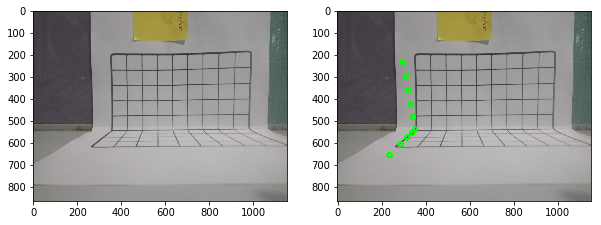

In [170]:
P,K,R,t,e,m,ni = dlt(img,img_coords,world_coords)
print("Projected Matrix")
print(P)
print("Intrinsic Matrix")
print(K)
print("Rotation Matrix")
print(R)
print("Translation Matrix")
print(t)
print("Error")
print(m)
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(ni)

### Different Scales

In [173]:
img = cv2.imread('Own/img11.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_coords = [(1325.9783233467983, 813.0997614076946), (1532.0353143724737, 769.7193422443943), (1765.2050673752124, 699.2261611040317), (1081.963465553235, 742.6065802673315), (827.1035029688469, 666.6908467315566), (1315.1332185559736, 1116.7626955507958)]
world_coords = [(0,0,0),(1,0,0),(2,0,0),(0,0,1),(0,0,2),(0,1,0)]
img_coords = np.asarray(img_coords).astype('float32')
world_coords = np.asarray(world_coords).astype('float32')

Projected Matrix
[[-7.01707085e-13  6.47277927e-01 -4.24110371e-13  3.21741852e-12]
 [-2.79898527e-13  7.62253862e-01 -1.05980315e-12  5.09584235e-12]
 [-6.66133815e-16  5.79602031e-04 -1.08055546e-16  3.77475828e-15]]
Intrinsic Matrix
[[ 3.24296535e+03 -3.79308739e+15  3.37650654e+03]
 [ 0.00000000e+00 -2.00978825e+15  3.55108943e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Rotation Matrix
[[-9.28833888e-01  3.70495147e-01 -9.76891467e-04]
 [-3.70495386e-01 -9.28834304e-01  6.91613817e-05]
 [-8.81746350e-04  4.26173216e-04  9.99999520e-01]]
Translation Matrix
[6.72361810e+00 1.50276681e-11 4.22448722e+00]
Error
1260.2968529718494


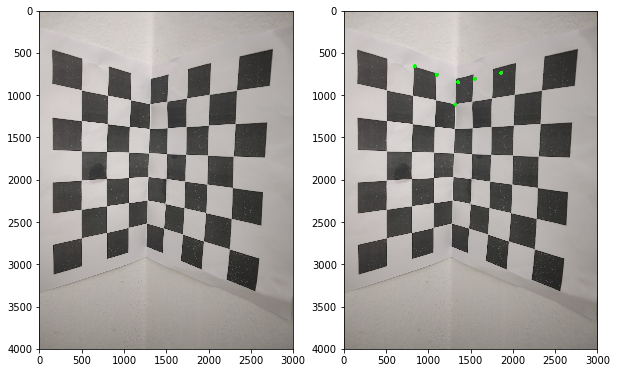

In [174]:
P,K,R,t,e,m,ni = dlt(img,img_coords,world_coords)
print("Projected Matrix")
print(P)
print("Intrinsic Matrix")
print(K)
print("Rotation Matrix")
print(R)
print("Translation Matrix")
print(t)
print("Error")
print(m)
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(ni)

In [175]:
img = cv2.imread('Own/img12.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_coords = [(1309.7106661605608, 834.7899709893445), (1423.5842664642237, 802.2546566168694), (1559.148076349537, 775.1418946398067), (1136.1889895073605, 813.0997614076946), (973.5124176449849, 785.9869994306318), (1304.288113765148, 1040.8469620150204)]
world_coords = [(0,0,0),(1,0,0),(2,0,0),(0,0,1),(0,0,2),(0,1,0)]
img_coords = np.asarray(img_coords).astype('float32')
world_coords = np.asarray(world_coords).astype('float32')

Projected Matrix
[[-8.47785206e-13  6.23750426e-01  8.74047322e-14 -3.18025771e-14]
 [-1.27359554e-12  7.81623341e-01  1.94420353e-13 -1.84820090e-13]
 [-8.88178420e-16  5.99272008e-04  1.33543026e-16 -5.55111512e-17]]
Intrinsic Matrix
[[ 7.66379427e+04 -4.99052854e+16 -1.05329815e+04]
 [ 0.00000000e+00  4.31376082e+15 -1.75187968e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Rotation Matrix
[[-5.54121455e-01  8.32435666e-01 -5.23760630e-04]
 [-8.32435629e-01 -5.54121649e-01 -3.48730596e-04]
 [-5.80522890e-04  2.42757904e-04  9.99999802e-01]]
Translation Matrix
[1.20162014e+00 1.40254572e-12 1.28224997e+00]
Error
438423.1241872798


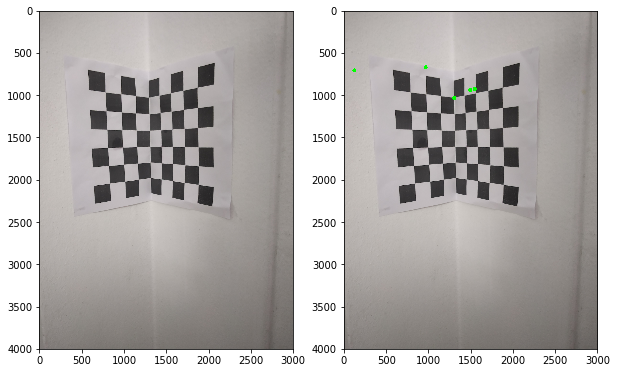

In [176]:
P,K,R,t,e,m,ni = dlt(img,img_coords,world_coords)
print("Projected Matrix")
print(P)
print("Intrinsic Matrix")
print(K)
print("Rotation Matrix")
print(R)
print("Translation Matrix")
print(t)
print("Error")
print(m)
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(ni)

### Zhangs Calibration

In [163]:
imgs = []
for i in range(1,6):
    ik = cv2.imread('Own/img'+str(i)+'.jpeg')
    ik = cv2.cvtColor(ik,cv2.COLOR_BGR2RGB)
    imgs.append(ik)

In [164]:
x,y = np.meshgrid(range(6),range(8))
world_pts = np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)))).astype('float32')

In [165]:
pts3d = []
pts2d = []
for i in imgs:
    ret,corners = cv2.findChessboardCorners(i,(6,8))
    if ret:
        pts2d.append(corners)
        pts3d.append(world_pts)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pts3d,pts2d, (i.shape[1],i.shape[0]), None, None)

In [166]:
print('Reprojection Error:', ret)
print ('Camera Calibration Matrix:')
print(mtx)
print('Distortion Parameters:')
print(dist)
print('Rotation Vectors for the images are:')
print(rvecs)
print('Translation Vectors for the images are:')
print(tvecs)

Reprojection Error: 2.2775225405922876
Camera Calibration Matrix:
[[987.99789828   0.         362.4744494 ]
 [  0.         982.59388936 619.9885207 ]
 [  0.           0.           1.        ]]
Distortion Parameters:
[[ 0.1819742  -0.61803462 -0.00376678  0.01351287  0.70875399]]
Rotation Vectors for the images are:
[array([[ 0.0575766 ],
       [ 0.39870349],
       [-0.01472371]]), array([[ 0.02624925],
       [-0.77616394],
       [ 0.00754543]]), array([[ 0.05299469],
       [-0.12727665],
       [ 0.00176436]]), array([[ 0.00353041],
       [-0.10591087],
       [ 0.00338543]]), array([[ 0.02650615],
       [-0.08551728],
       [ 0.00079721]])]
Translation Vectors for the images are:
[array([[-2.2931373 ],
       [-5.34907031],
       [16.55435457]]), array([[-3.41610575],
       [-5.10854248],
       [15.63930712]]), array([[-4.89466589],
       [-7.81454241],
       [17.51461527]]), array([[-3.72374922],
       [-0.84914217],
       [15.40994873]]), array([[-3.20623473],
       

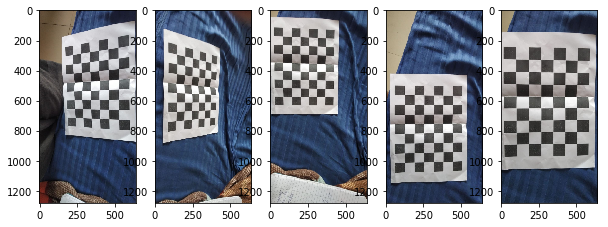

In [171]:
plt.figure(figsize=(10,50))
for i in range(len(imgs)):
    plt.subplot(1,5,i+1)
    plt.imshow(imgs[i])
